In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pytorch_ssim
# https://github.com/Po-Hsun-Su/pytorch-ssim
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 选择 dataset
batch_size = 10
eps = 0.3
step_size = 0.2
iteration = 10
K = 0.05

In [3]:
def filter_state_dict(state_dict):
    from collections import OrderedDict

    if 'state_dict' in state_dict.keys():
        state_dict = state_dict['state_dict']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if 'sub_block' in k:
            continue
        if 'module' in k:
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[None, :, None, None]

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = torchvision.datasets.FashionMNIST("data_FashionMNIST", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
import model.small_cnn as small_cnn
model = small_cnn.SmallCNN()
#check_point = torch.load("pretrained_model/MNIST_small_cnn.checkpoint", map_location=torch.device(device))
check_point = torch.load("model/FashionMNIST_small_cnn_10.checkpoint")
model.load_state_dict(check_point)
#model.load_state_dict(check_point['state_dict'])
model.to(device)

SmallCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (layer_one): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU(inplace=True)
  )
  (feature_extractor): Sequential(
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU(inplace=True)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu4): ReLU(inplace=True)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (fc1): Linear(in_features=1024, out_features=200, bias=True)
    (relu1): ReLU(inplace=True)
    (drop): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (relu2): ReLU(inplace=True)
    (fc3): Linear(in_features=200, o

In [5]:
def multi_imshow(imglist, labellist):
    figNum = len(imglist)
    plt.figure(figsize=(5*figNum, 5))
    namelist = []
    for i in range(1, figNum + 1):
        namelist.append('img' + str(i))
        namelist[i - 1] = plt.subplot2grid((1, figNum),(0, i - 1))
        plt.imshow(np.transpose(imglist[i - 1].cpu(),(1,2,0)))
        namelist[i - 1].set_title(labellist[i - 1])
    plt.show()
    # sp = savepath + "img" + str(figNum) + '.png'
    # plt.savefig(sp)

In [6]:
# l2 Loss
def l2(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0.0
    for i in range(0,channel):
        for j in range(0,height):
            for k in range(0, width):
                total_dif += (img1[i][j][k].item()-img2[i][j][k].item()) ** 2
    return total_dif ** 0.5

In [7]:
# l1 Loss
def l1(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0
    for i in range(0, channel):
        for j in range(0, height):
            for k in range(0, width):
                total_dif += abs(img1[i][j][k].item() - img2[i][j][k].item())
    return total_dif

In [8]:
# l0 Loss 计算差距<=0.01像素点的数目
def l0(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0
    for i in range(0, channel):
        for j in range(0, height):
            for k in range(0, width):
                total_dif += 0 if abs(img1[i][j][k].item() - img2[i][j][k].item()) <= 0.01 else 1
    return total_dif

In [9]:
class My_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, delta, y, images, lam1 , lam2 ):
        mask = torch.ones_like(x).scatter_(1, y.unsqueeze(1), 0.)
        rest = x[mask.bool()].view(x.size(0), x.size(1) - 1)
        xx = torch.tensor(range(x.size(0)))
        f = torch.nn.ReLU()
        loss_attack = 1*f(x[xx, y] - torch.max(rest, 1)[0] + K)
        #print(loss_attack)
        loss_ssim = 0.01*lam1 *(1 - (pytorch_ssim.ssim(images,images+delta)))
        #loss_L_inf = 0.1*lam2 * (torch.max(torch.abs(delta)))
        loss_L_2 = 0.5*lam2 * torch.dist(images,images+delta ,p=2)
        img = images+delta
        loss_var = 500*(torch.norm(img[:,:,1:,:] - img[:,:,:-1,:])+torch.norm(img[:,:,:,1:] - img[:,:,:,:-1]))/(images.size(0)*images.size(1)*images.size(2)*images.size(3))
        #print(loss_var)
        #loss_var = 100* (torch.norm(torch.Tensor(np.gradient((images+delta).detach().cpu().numpy(),axis=(2,3))))/(images.size(0)*images.size(1)*images.size(2)*images.size(3))).to(device)
        return torch.mean(loss_attack + loss_ssim + loss_L_2)+loss_var
        #return torch.mean(f(x[xx, y] - torch.max(rest, 1)[0] + K) + lam *(eps + torch.max(delta)))

In [10]:
def PGD_attack_MyLoss(net, images, labels, eps, step_size):
    images = images.to(device)
    labels = labels.to(device)

    delta = torch.zeros(images.size()).to(device)  #变量求导
    lam1 = torch.zeros(1).to(device)
    lam2 = torch.zeros(1).to(device)
    #delta.uniform_(-eps, eps).to(device)
    delta = Variable(delta, requires_grad=True)
    lam1 = Variable(lam1,requires_grad=True)
    lam2 = Variable(lam2,requires_grad=True)
    # print(images.size())
    # print(labels.size())
    # ori_images = images.data
    criterion = My_loss()
    for i in range(iteration):
        # delta.requires_grad = True
        # lam.requires_grad = True
        # print(images.size())
        outputs = net(images + delta)
        net.zero_grad()
        loss = criterion(outputs, delta, labels,images,lam1,lam2).to(device)
        loss.backward()

        # print(delta.grad)
        new_delta = delta - step_size * delta.grad.detach()
        adv_images = torch.clamp(images + new_delta, min=0, max=1)
        delta = adv_images - images
        new_lam1 = lam1 + step_size * lam1.grad.detach()
        if new_lam1 < 0:
            lam1 = torch.zeros(1).to(device)
        else:
            lam1 = new_lam1
            
        new_lam2 = lam2 + step_size *0.3* lam2.grad.detach()
        if new_lam2 < 0:
            lam2 = torch.zeros(1).to(device)
        else:
            lam2 = new_lam2
            
        # delta = torch.clamp(delta, min=-eps, max=eps)
        delta = Variable(delta, requires_grad=True)
        lam1 = Variable(lam1,requires_grad=True)
        lam2 = Variable(lam2,requires_grad=True)
        # for i in range(0, images.size()[0]):
        #     print(torch.max(delta[i]).item())
        #     print(torch.min(delta[i]).item())
    deltas = []
    for i in range(0,images.size()[0]):
        deltas.append(torch.max(torch.abs(delta[i])).item())
    return images + delta, deltas

In [11]:
def PGD_attack_Conventional(model, image, label, eps, step_size, iters=10):
    image = image.to(device)
    label = label.to(device)
    loss = nn.NLLLoss()
    ori_image = image.data

    for i in range(iters):
        image.requires_grad = True
        output = model(image)
        model.zero_grad()
        cost = loss(output, label).to(device)
        cost.backward()
        adv_image = image + step_size * image.grad.sign()
        delta = torch.clamp(adv_image - ori_image, min=-eps, max=eps)
        image = torch.clamp(ori_image + delta, min=0, max=1).detach_()
    deltas = []
    delta = image-ori_image 
    for i in range(0,images.size()[0]):
        deltas.append(torch.max(torch.abs(delta[i])).item())
    return image ,deltas 

In [12]:
def fsgm_attack(model, image, label, eps):
    image = image.to(device)
    label = label.to(device)
    loss = nn.NLLLoss()

    image.requires_grad = True
    output = model(image)
    model.zero_grad()
    cost = loss(output, label).to(device)
    cost.backward()

    image = image + eps * image.grad.sign()
    image = torch.clamp(image, min=0, max=1)
    return image

In [13]:
def cw_l2_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01) :
    import torch.optim as optim
    images = images.to(device)     
    labels = labels.to(device)

    # Define f-function
    def f(x) :

        outputs = model(x)
        one_hot_labels = torch.eye(len(outputs[0]))[labels].to(device)

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.byte())
        
        # If targeted, optimize for making the other class most likely 
        if targeted :
            return torch.clamp(i-j, min=-kappa)
        
        # If untargeted, optimize for making the other class most likely 
        else :
            return torch.clamp(j-i, min=-kappa)
    
    w = torch.zeros_like(images, requires_grad=True).to(device)

    optimizer = optim.Adam([w], lr=learning_rate)

    prev = 1e10
    
    for step in range(max_iter) :

        a = 1/2*(nn.Tanh()(w) + 1)

        #loss1 = nn.MSELoss(reduction='sum')(a, images)
        loss1 = torch.mean(torch.dist(images,a ,p=2))
        #loss1 = torch.mean(torch.max(torch.abs(a-images)))
        loss2 = torch.mean(c*f(a))

        cost = loss1 + loss2

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Early Stop when loss does not converge.
        if step % (max_iter//10) == 0 :
            if cost > prev :
                print('Attack Stopped due to CONVERGENCE....')
                delta = a -images
                deltas=[]
                for i in range(0,images.size()[0]):
                    deltas.append(torch.max(torch.abs(delta[i])).item())                
                return a, deltas
            prev = cost
        
        print('- Learning Progress : %2.2f %%        ' %((step+1)/max_iter*100), end='\r')

    attack_images = 1/2*(nn.Tanh()(w) + 1)

    delta = attack_images -images
    deltas=[]
    for i in range(0,images.size()[0]):
        deltas.append(torch.max(torch.abs(delta[i])).item())
        
    return attack_images, deltas

Total Image Count: 6 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.6666666666666666 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.946 PGD_attack: 0.647 FSGM_attack: 0.405 CW_attack: 0.0
Total Image Count: 10 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.8 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.913 PGD_attack: 0.615 FSGM_attack: 0.357 CW_attack: 0.0
Total Image Count: 14 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.8571428571428571 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.925 PGD_attack: 0.607 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 15 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.8666666666666667 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.904 PGD_attack: 0.605 FSGM_attack: 0.351 CW_attack: 0.0
Total Image Count: 22 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.8181818181818182 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.925 PGD_attack: 0.614 FSGM_attack: 0.348 CW_attack: 0.0
Total 

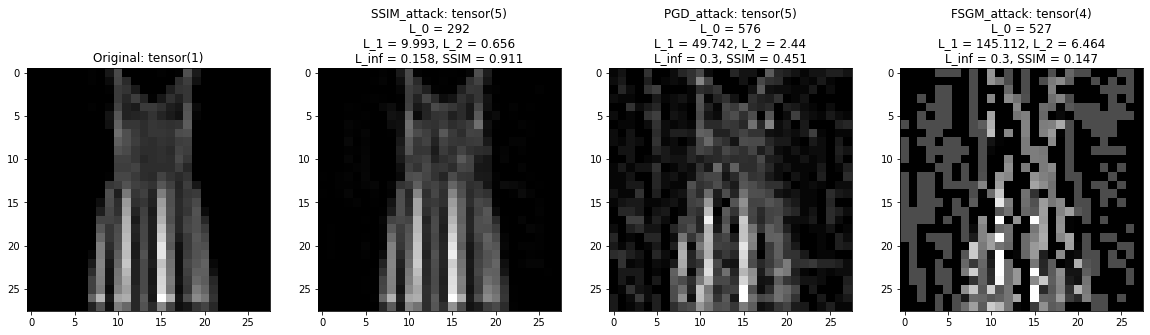

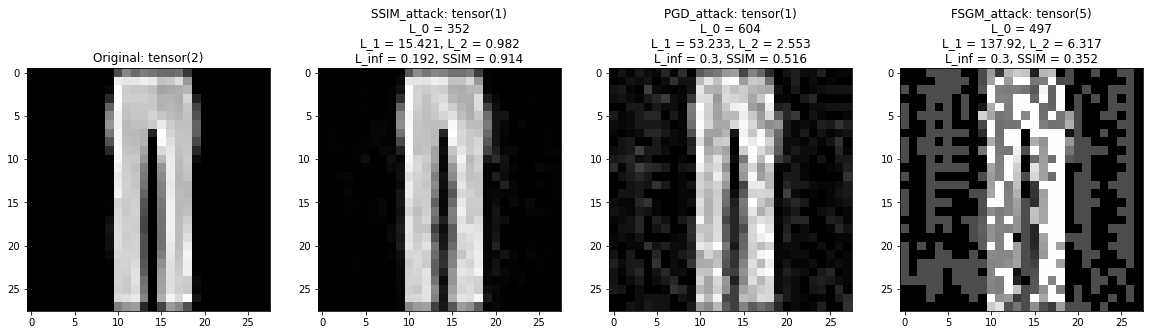

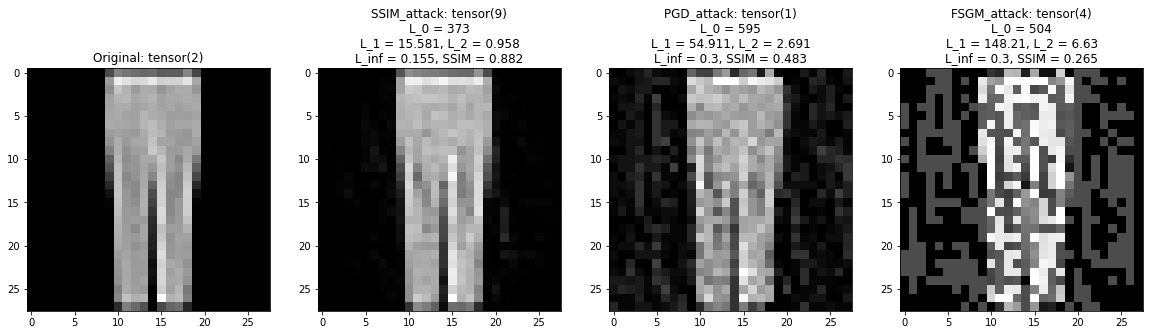

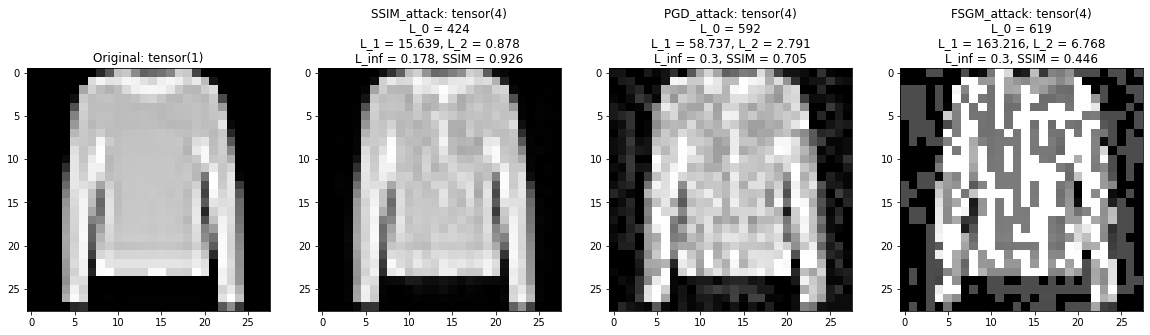

Total Image Count: 46 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.8913043478260869 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.926 PGD_attack: 0.622 FSGM_attack: 0.361 CW_attack: 0.0
Total Image Count: 49 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.8775510204081632 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.927 PGD_attack: 0.625 FSGM_attack: 0.358 CW_attack: 0.0
Total Image Count: 55 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.8727272727272727 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.93 PGD_attack: 0.635 FSGM_attack: 0.36 CW_attack: 0.0
Total Image Count: 61 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.8852459016393442 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.932 PGD_attack: 0.633 FSGM_attack: 0.361 CW_attack: 0.0
Total Image Count: 69 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.8840579710144928 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.935 PGD_attack: 0.63 FSGM_attack: 0.359 CW_attac

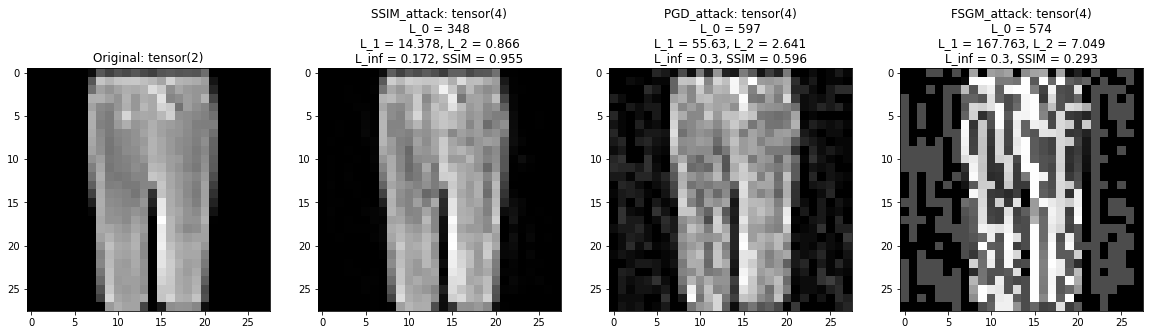

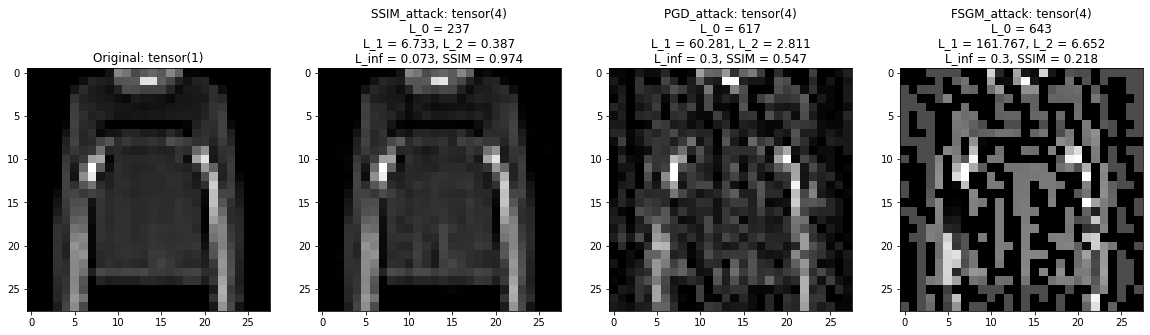

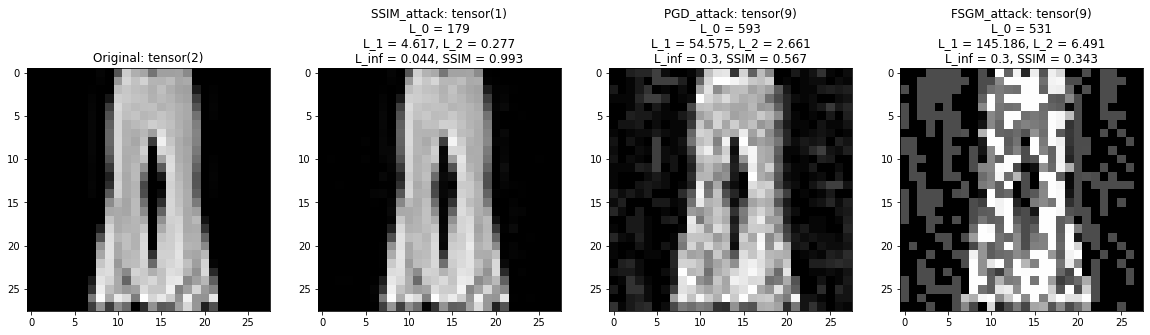

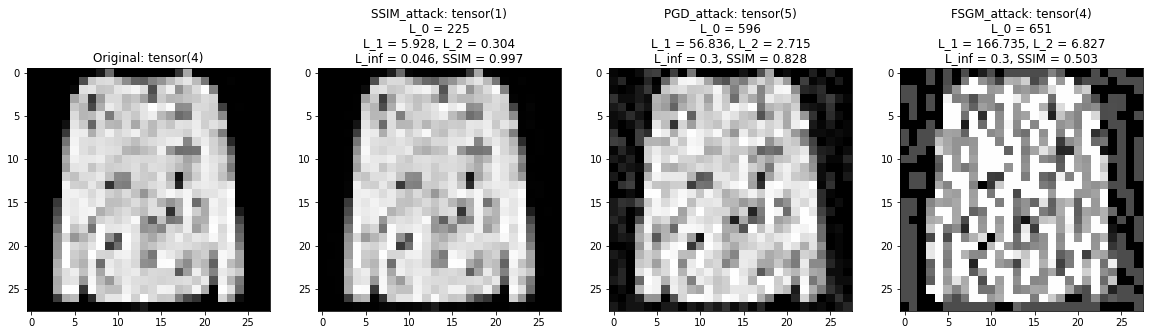

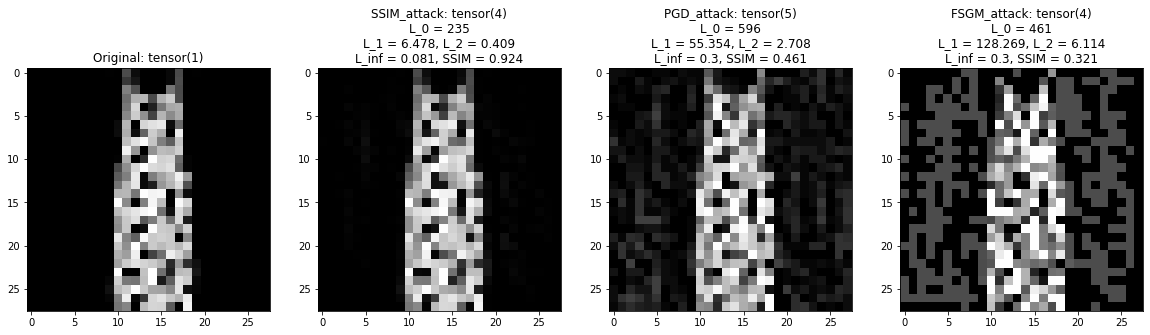

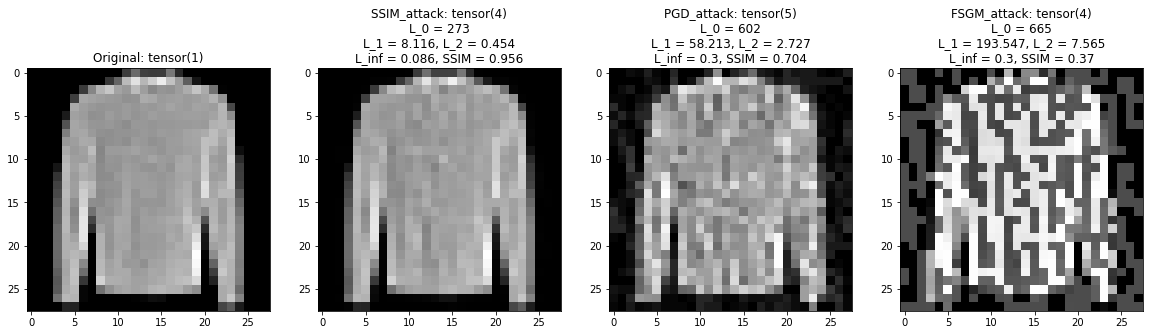

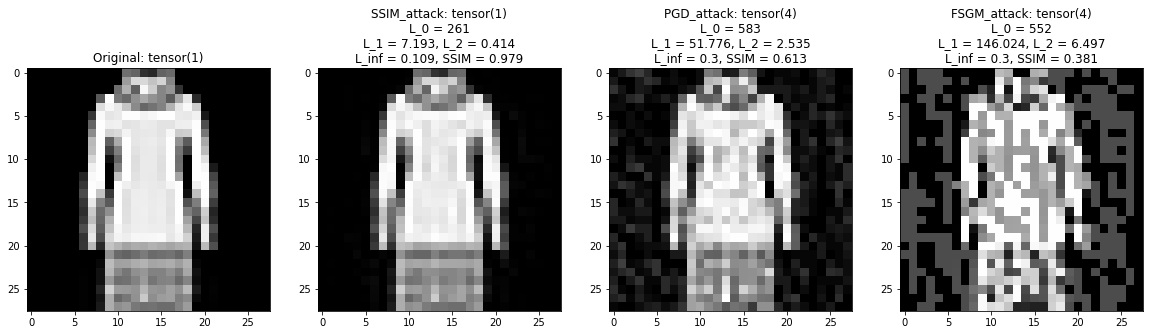

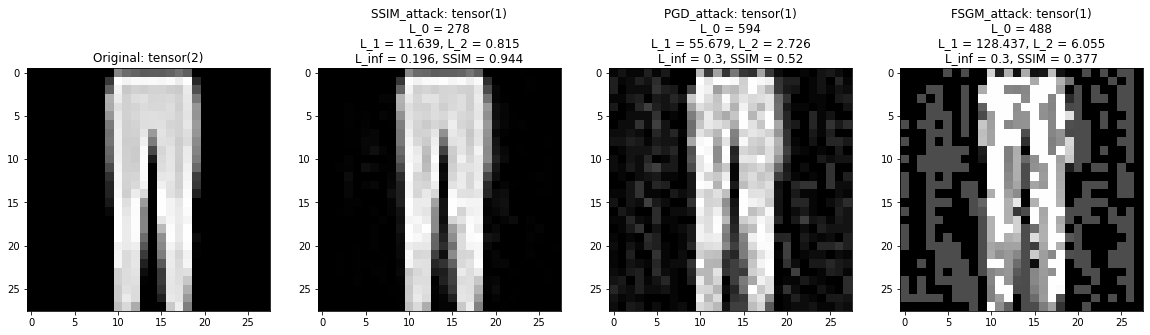

Total Image Count: 101 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.8910891089108911 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.931 PGD_attack: 0.62 FSGM_attack: 0.356 CW_attack: 0.0
Total Image Count: 107 Success Rate:
 SSIM_attack: 1.0 PGD_attack: 1.0 FSGM_attack: 0.897196261682243 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.932 PGD_attack: 0.618 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 113 Success Rate:
 SSIM_attack: 0.9911504424778761 PGD_attack: 1.0 FSGM_attack: 0.8938053097345132 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.932 PGD_attack: 0.617 FSGM_attack: 0.351 CW_attack: 0.0
Total Image Count: 118 Success Rate:
 SSIM_attack: 0.9915254237288136 PGD_attack: 1.0 FSGM_attack: 0.8983050847457628 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.933 PGD_attack: 0.618 FSGM_attack: 0.35 CW_attack: 0.0
Total Image Count: 123 Success Rate:
 SSIM_attack: 0.991869918699187 PGD_attack: 1.0 FSGM_attack: 0.9024390243902439 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.

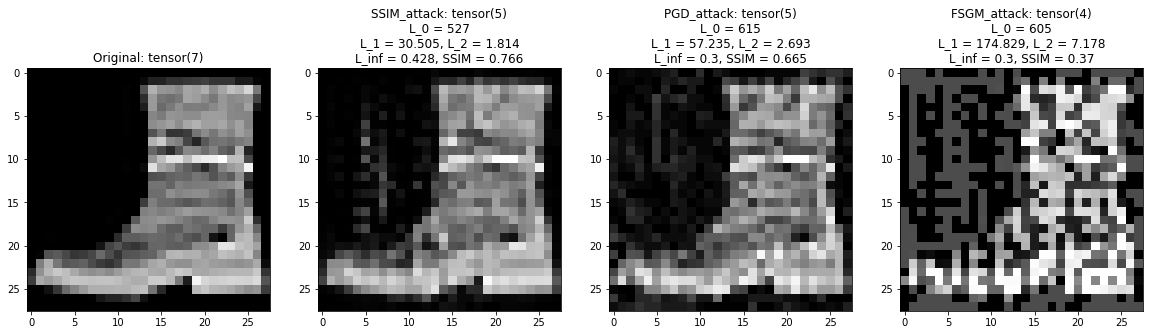

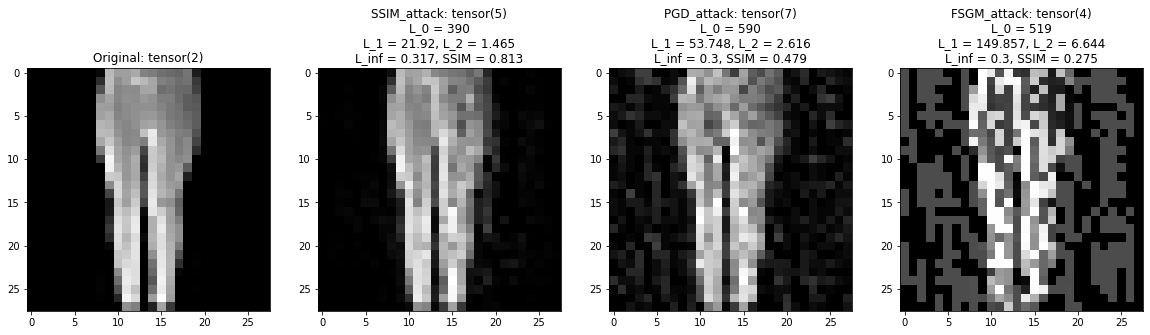

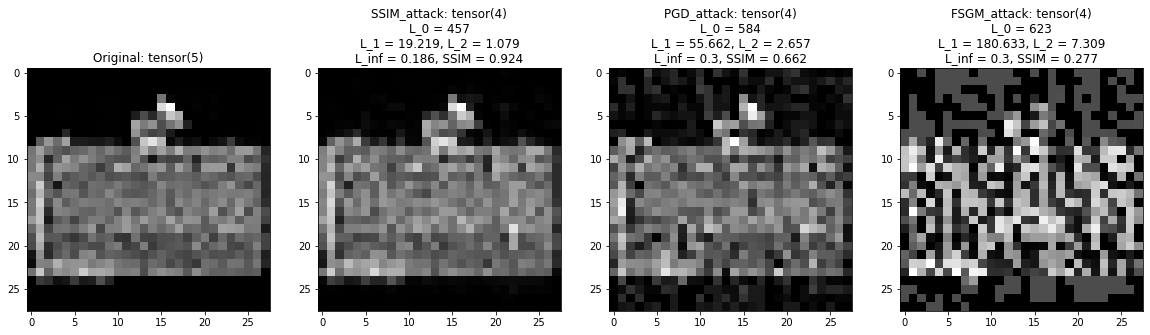

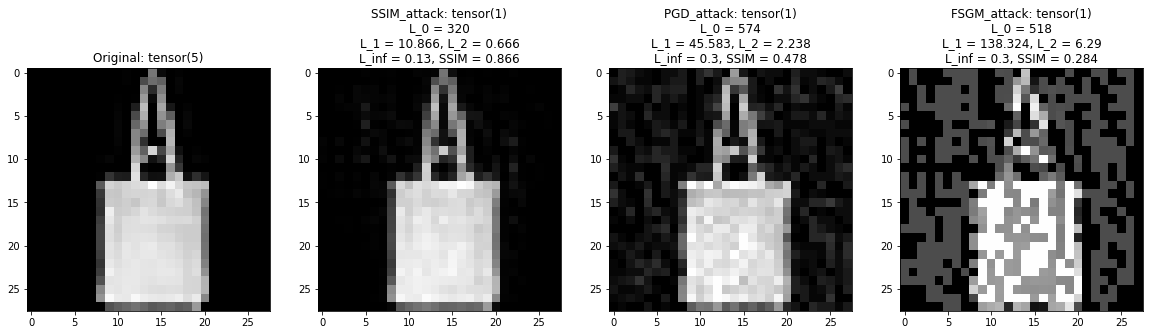

Total Image Count: 154 Success Rate:
 SSIM_attack: 0.9935064935064936 PGD_attack: 1.0 FSGM_attack: 0.8961038961038961 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.932 PGD_attack: 0.619 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 158 Success Rate:
 SSIM_attack: 0.9936708860759493 PGD_attack: 1.0 FSGM_attack: 0.8987341772151899 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.931 PGD_attack: 0.619 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 165 Success Rate:
 SSIM_attack: 0.9878787878787879 PGD_attack: 1.0 FSGM_attack: 0.8909090909090909 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.931 PGD_attack: 0.619 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 167 Success Rate:
 SSIM_attack: 0.9880239520958084 PGD_attack: 1.0 FSGM_attack: 0.8922155688622755 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.93 PGD_attack: 0.619 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 172 Success Rate:
 SSIM_attack: 0.9883720930232558 PGD_attack: 1.0 FSGM_attack: 0.8953488372093024 CW_attack: 

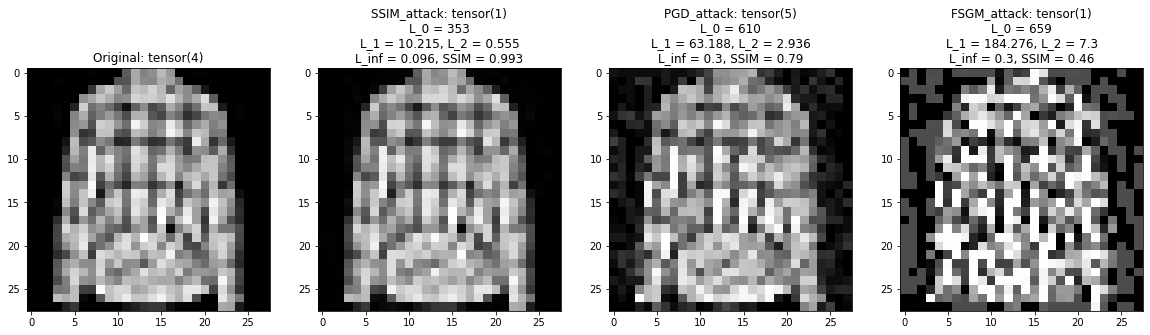

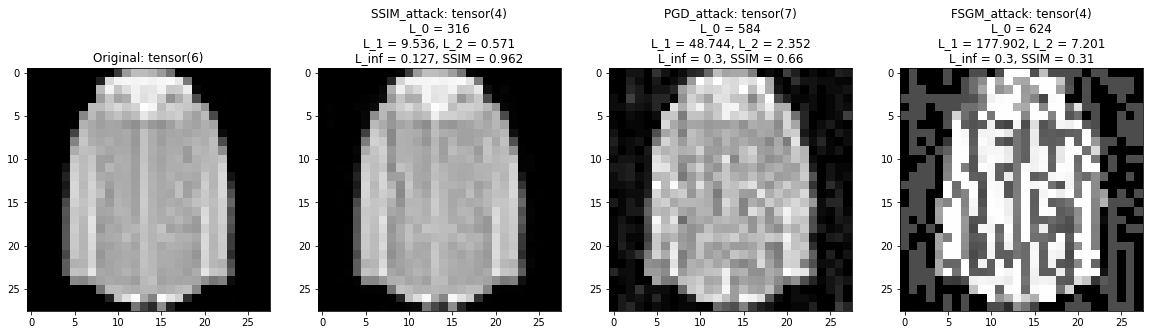

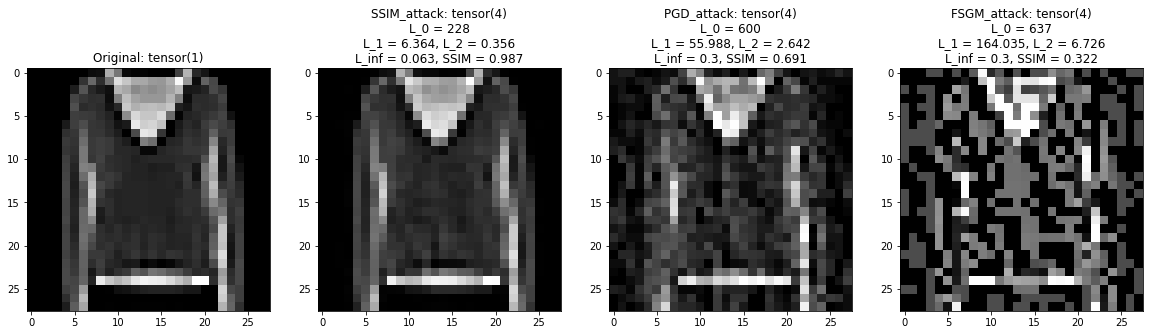

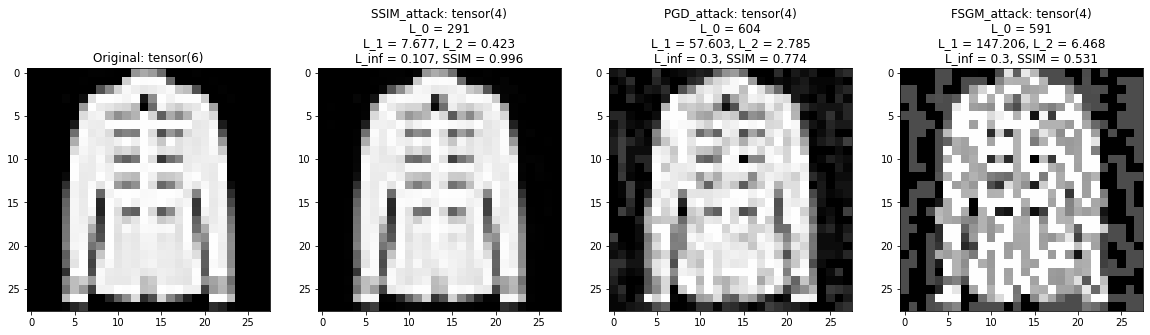

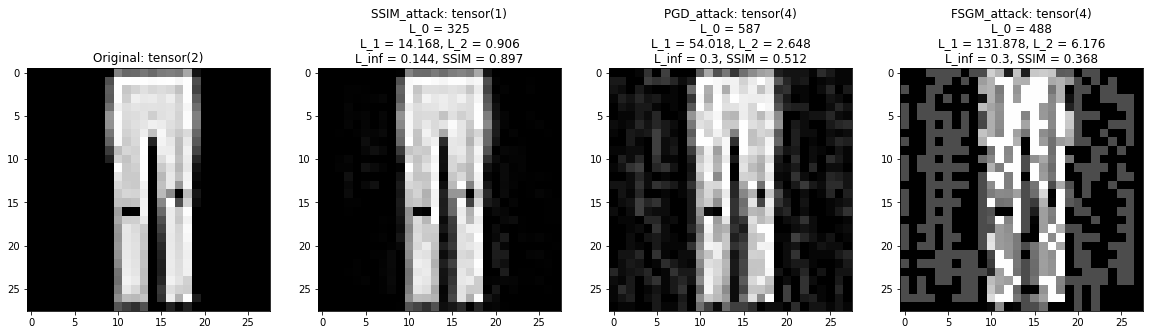

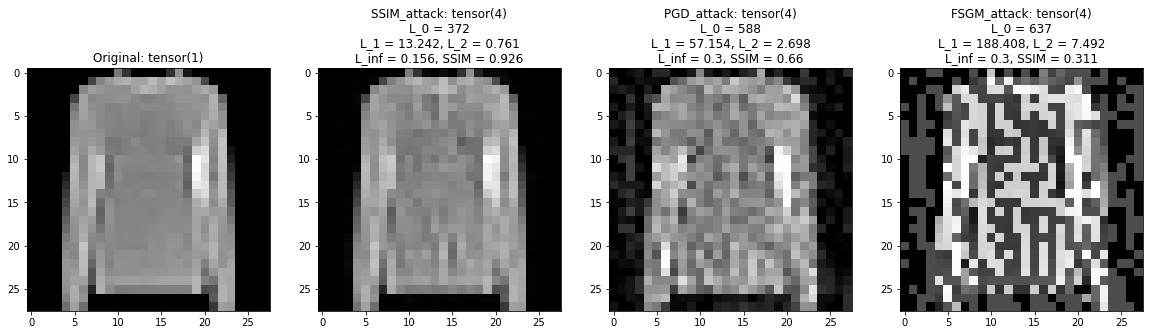

Total Image Count: 214 Success Rate:
 SSIM_attack: 0.9906542056074766 PGD_attack: 1.0 FSGM_attack: 0.897196261682243 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.936 PGD_attack: 0.62 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 219 Success Rate:
 SSIM_attack: 0.9908675799086758 PGD_attack: 1.0 FSGM_attack: 0.8949771689497716 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.936 PGD_attack: 0.62 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 223 Success Rate:
 SSIM_attack: 0.9910313901345291 PGD_attack: 1.0 FSGM_attack: 0.8968609865470852 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.935 PGD_attack: 0.62 FSGM_attack: 0.353 CW_attack: 0.0
Total Image Count: 229 Success Rate:
 SSIM_attack: 0.9912663755458515 PGD_attack: 1.0 FSGM_attack: 0.8995633187772926 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.935 PGD_attack: 0.622 FSGM_attack: 0.353 CW_attack: 0.0
Total Image Count: 234 Success Rate:
 SSIM_attack: 0.9914529914529915 PGD_attack: 1.0 FSGM_attack: 0.8974358974358975 CW_attack: 0.0

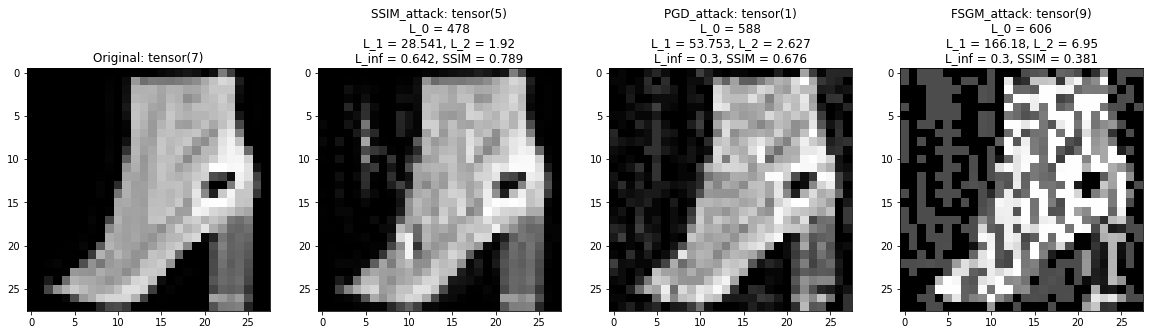

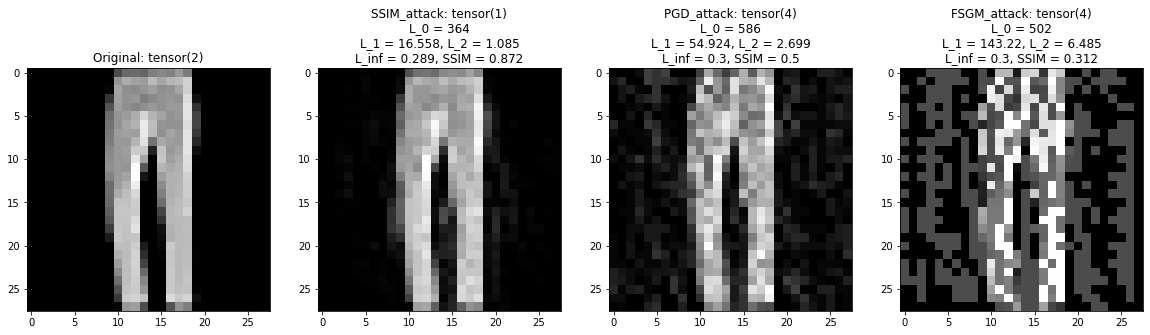

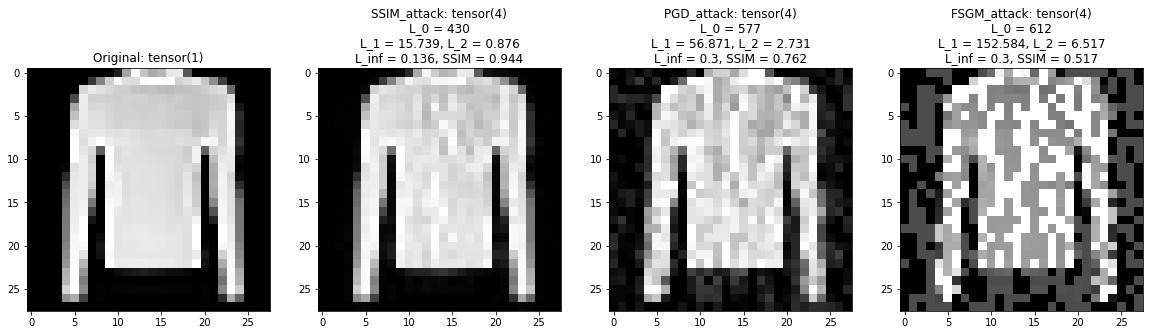

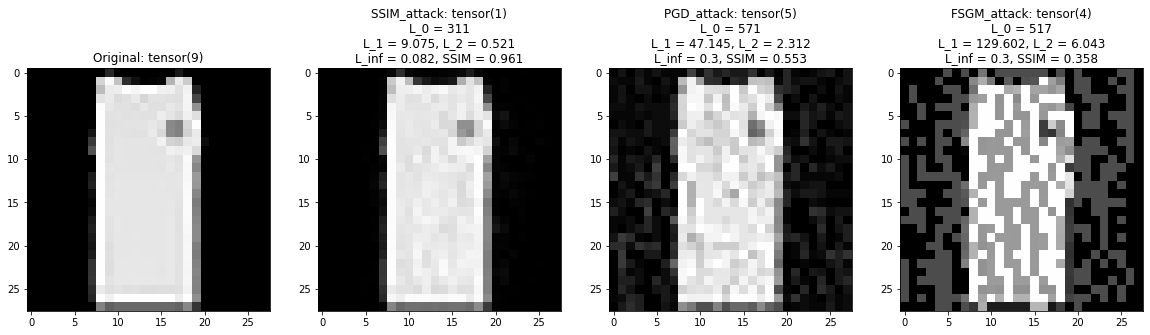

Total Image Count: 262 Success Rate:
 SSIM_attack: 0.9923664122137404 PGD_attack: 1.0 FSGM_attack: 0.9083969465648855 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.937 PGD_attack: 0.622 FSGM_attack: 0.353 CW_attack: 0.0
Total Image Count: 269 Success Rate:
 SSIM_attack: 0.9888475836431226 PGD_attack: 1.0 FSGM_attack: 0.9107806691449815 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.938 PGD_attack: 0.624 FSGM_attack: 0.354 CW_attack: 0.0
Total Image Count: 276 Success Rate:
 SSIM_attack: 0.9891304347826086 PGD_attack: 1.0 FSGM_attack: 0.9094202898550725 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.938 PGD_attack: 0.623 FSGM_attack: 0.354 CW_attack: 0.0
Total Image Count: 282 Success Rate:
 SSIM_attack: 0.9893617021276596 PGD_attack: 1.0 FSGM_attack: 0.9113475177304965 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.939 PGD_attack: 0.625 FSGM_attack: 0.354 CW_attack: 0.0
Total Image Count: 287 Success Rate:
 SSIM_attack: 0.9895470383275261 PGD_attack: 1.0 FSGM_attack: 0.9128919860627178 CW_attack:

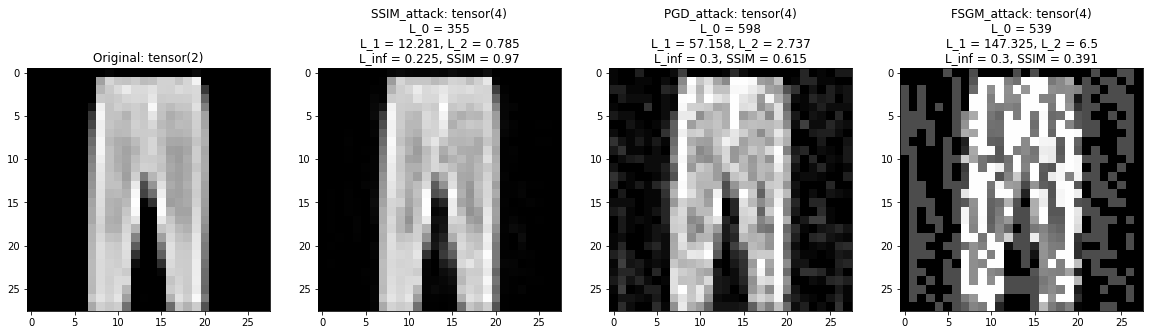

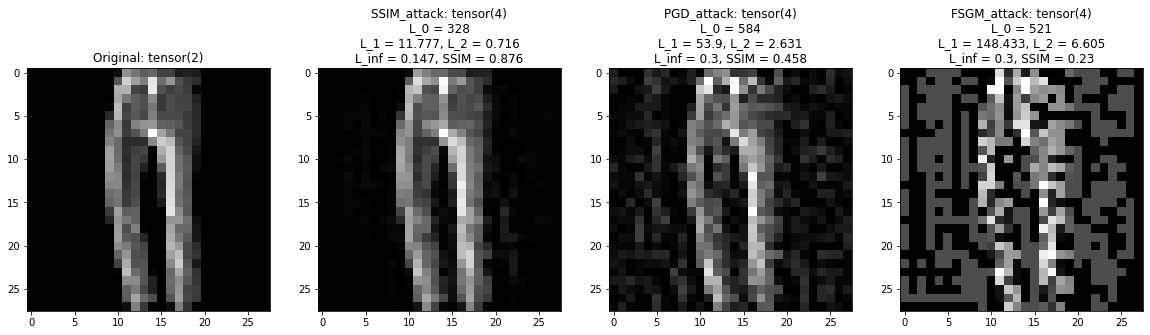

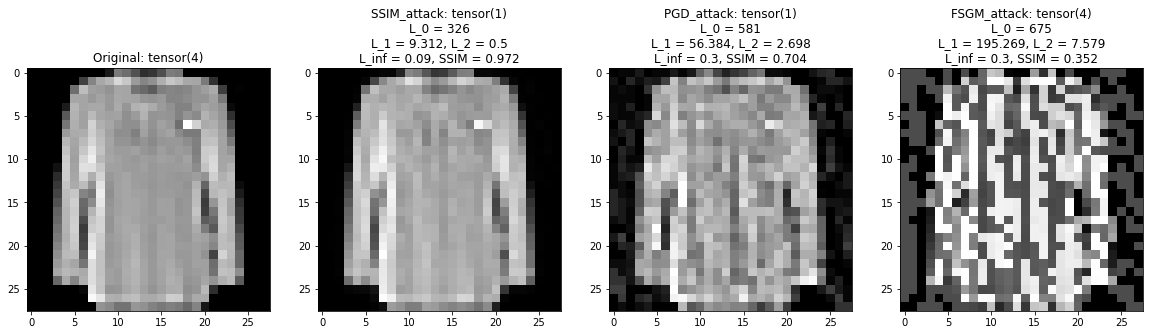

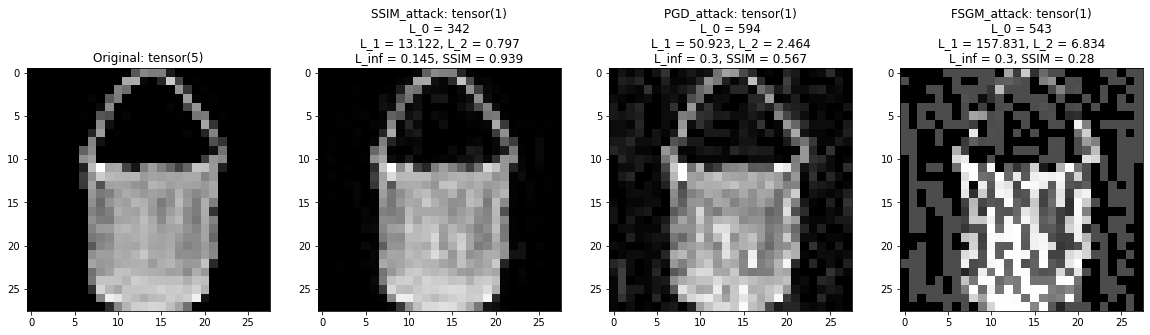

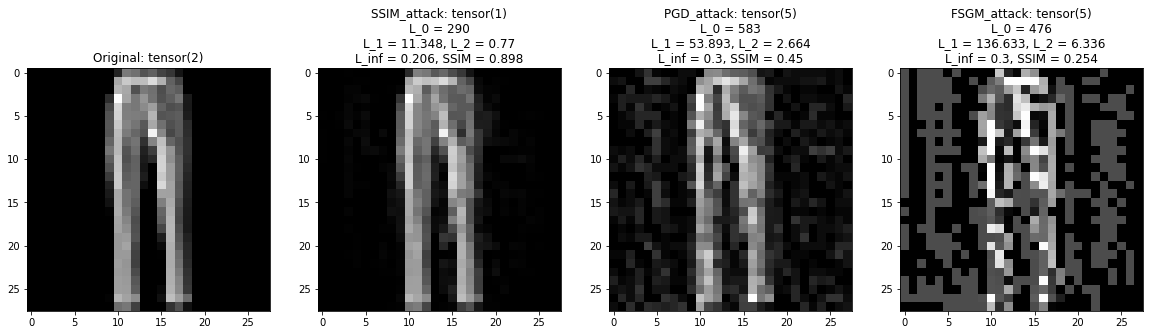

Total Image Count: 315 Success Rate:
 SSIM_attack: 0.9904761904761905 PGD_attack: 1.0 FSGM_attack: 0.9111111111111111 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.938 PGD_attack: 0.622 FSGM_attack: 0.351 CW_attack: 0.0
Total Image Count: 319 Success Rate:
 SSIM_attack: 0.9905956112852664 PGD_attack: 1.0 FSGM_attack: 0.9122257053291536 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.937 PGD_attack: 0.622 FSGM_attack: 0.351 CW_attack: 0.0
Total Image Count: 326 Success Rate:
 SSIM_attack: 0.99079754601227 PGD_attack: 1.0 FSGM_attack: 0.9141104294478528 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.938 PGD_attack: 0.623 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 332 Success Rate:
 SSIM_attack: 0.9909638554216867 PGD_attack: 1.0 FSGM_attack: 0.9126506024096386 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.938 PGD_attack: 0.625 FSGM_attack: 0.353 CW_attack: 0.0
Total Image Count: 335 Success Rate:
 SSIM_attack: 0.991044776119403 PGD_attack: 1.0 FSGM_attack: 0.9104477611940298 CW_attack: 0.

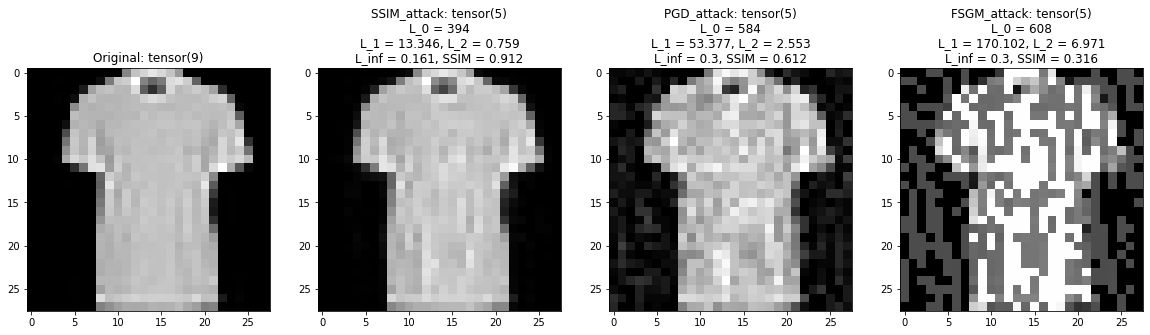

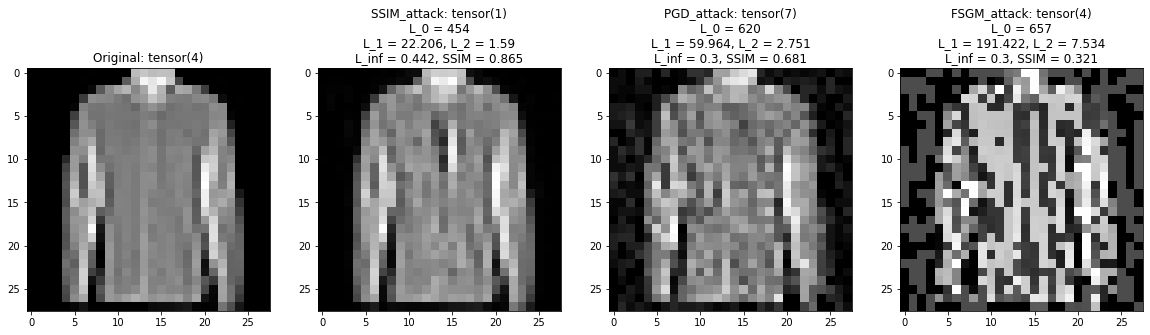

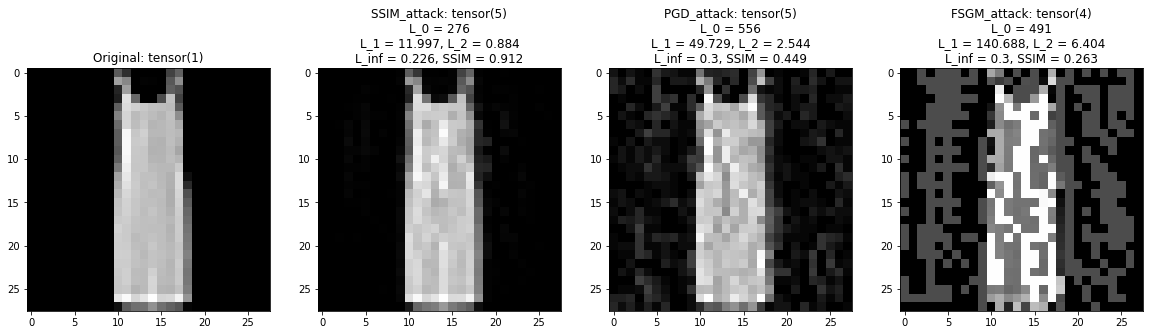

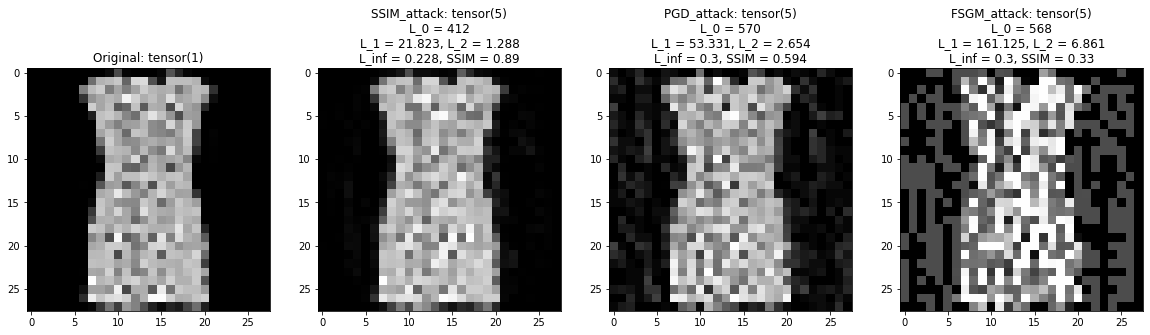

Total Image Count: 363 Success Rate:
 SSIM_attack: 0.9917355371900827 PGD_attack: 1.0 FSGM_attack: 0.9146005509641874 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.938 PGD_attack: 0.626 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 365 Success Rate:
 SSIM_attack: 0.9917808219178083 PGD_attack: 1.0 FSGM_attack: 0.915068493150685 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.938 PGD_attack: 0.626 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 369 Success Rate:
 SSIM_attack: 0.991869918699187 PGD_attack: 1.0 FSGM_attack: 0.9159891598915989 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.937 PGD_attack: 0.625 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 372 Success Rate:
 SSIM_attack: 0.9919354838709677 PGD_attack: 1.0 FSGM_attack: 0.9139784946236559 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.937 PGD_attack: 0.625 FSGM_attack: 0.351 CW_attack: 0.0
Total Image Count: 376 Success Rate:
 SSIM_attack: 0.9920212765957447 PGD_attack: 1.0 FSGM_attack: 0.9148936170212766 CW_attack: 0

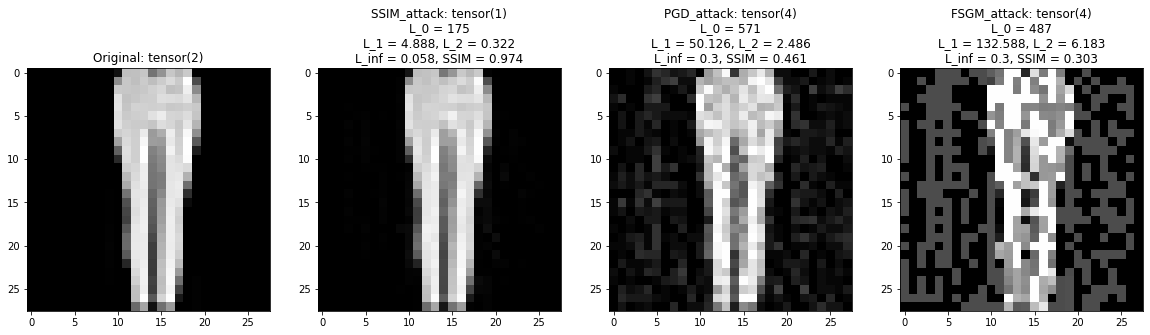

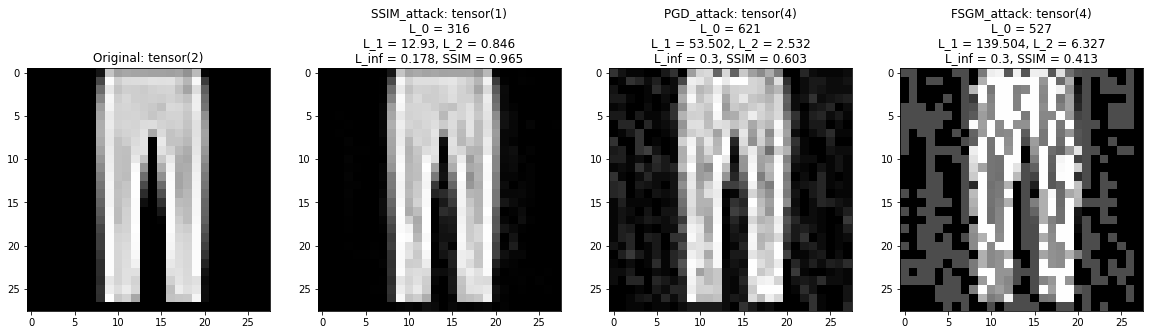

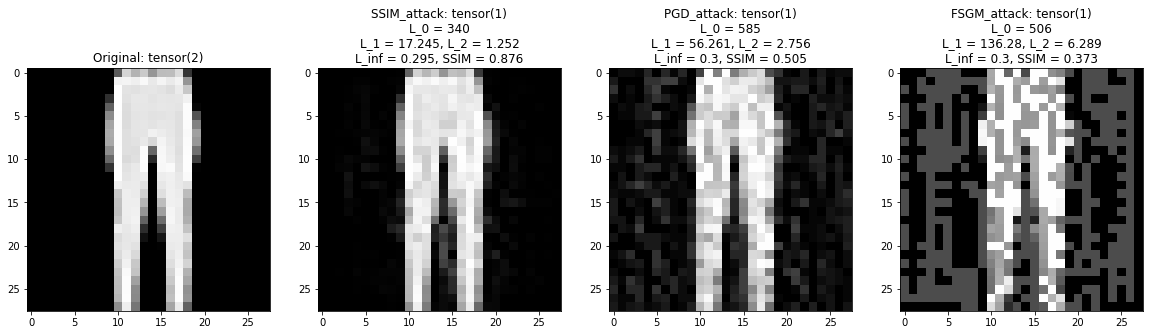

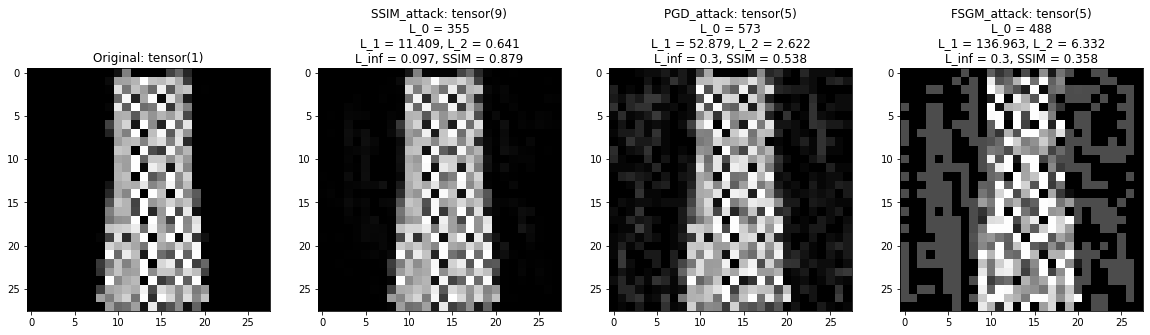

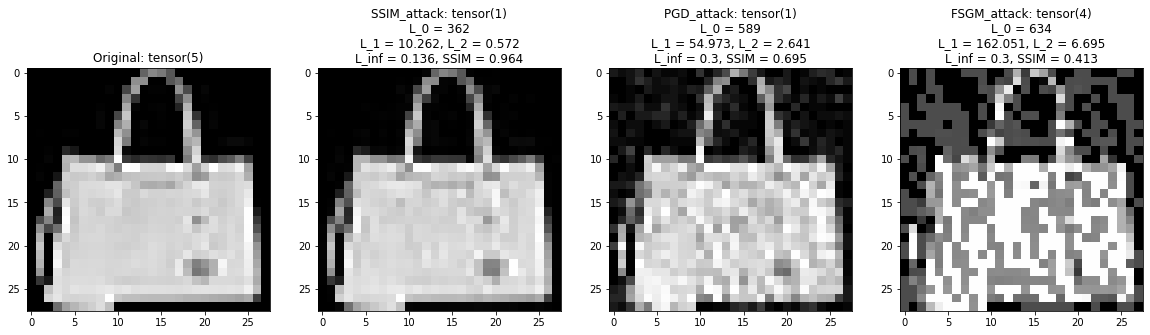

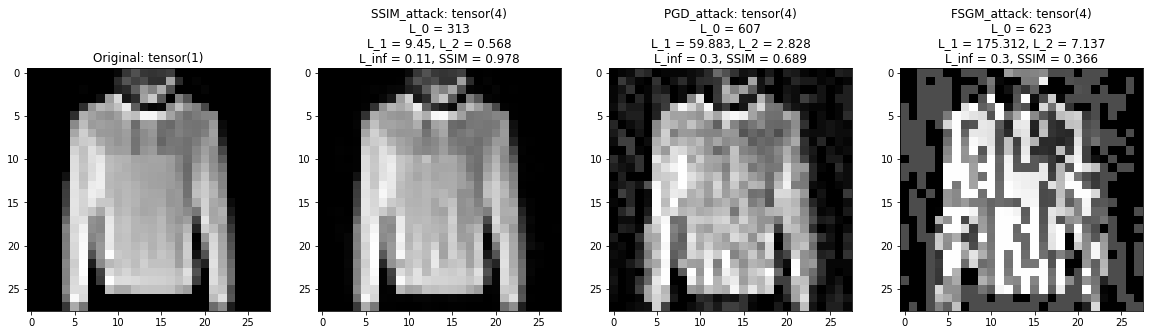

Total Image Count: 405 Success Rate:
 SSIM_attack: 0.9925925925925926 PGD_attack: 1.0 FSGM_attack: 0.9160493827160494 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.936 PGD_attack: 0.624 FSGM_attack: 0.351 CW_attack: 0.0
Total Image Count: 409 Success Rate:
 SSIM_attack: 0.9926650366748166 PGD_attack: 1.0 FSGM_attack: 0.9168704156479217 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.936 PGD_attack: 0.624 FSGM_attack: 0.351 CW_attack: 0.0
Total Image Count: 413 Success Rate:
 SSIM_attack: 0.9927360774818402 PGD_attack: 1.0 FSGM_attack: 0.9176755447941889 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.936 PGD_attack: 0.624 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 415 Success Rate:
 SSIM_attack: 0.9927710843373494 PGD_attack: 1.0 FSGM_attack: 0.9180722891566265 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.936 PGD_attack: 0.624 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 421 Success Rate:
 SSIM_attack: 0.9928741092636579 PGD_attack: 1.0 FSGM_attack: 0.9192399049881235 CW_attack:

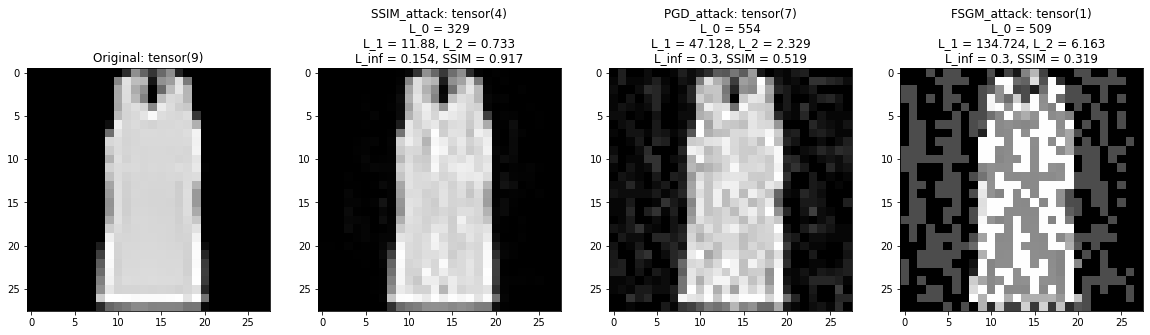

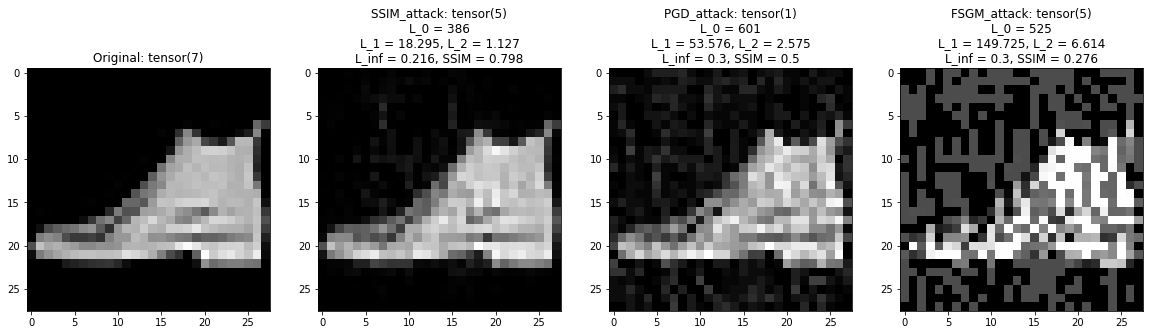

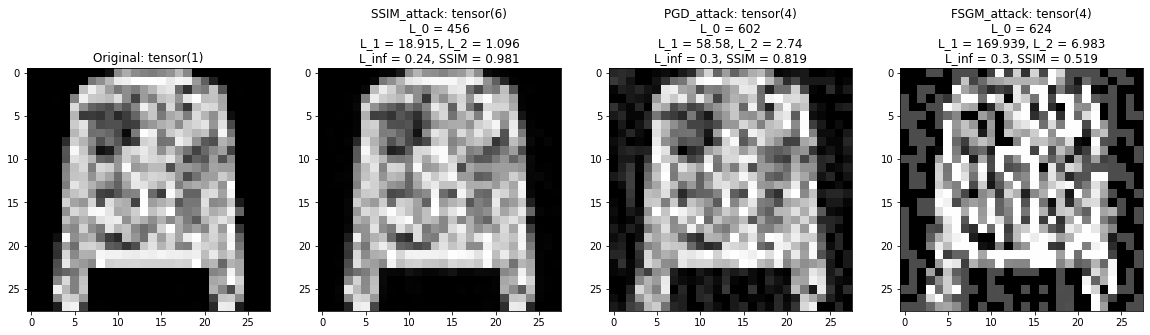

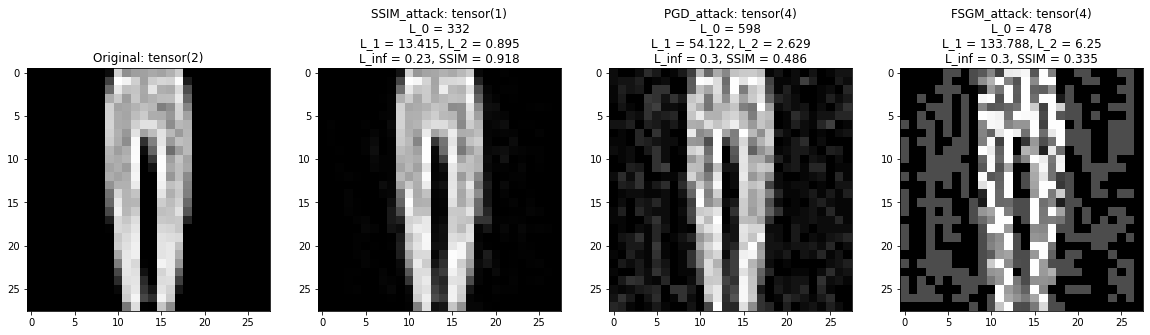

Total Image Count: 448 Success Rate:
 SSIM_attack: 0.9933035714285714 PGD_attack: 1.0 FSGM_attack: 0.9196428571428571 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.935 PGD_attack: 0.62 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 451 Success Rate:
 SSIM_attack: 0.9933481152993349 PGD_attack: 1.0 FSGM_attack: 0.9201773835920177 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.935 PGD_attack: 0.621 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 457 Success Rate:
 SSIM_attack: 0.9934354485776805 PGD_attack: 1.0 FSGM_attack: 0.9212253829321663 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.935 PGD_attack: 0.621 FSGM_attack: 0.353 CW_attack: 0.0
Total Image Count: 463 Success Rate:
 SSIM_attack: 0.9935205183585313 PGD_attack: 1.0 FSGM_attack: 0.9200863930885529 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.935 PGD_attack: 0.62 FSGM_attack: 0.352 CW_attack: 0.0
Total Image Count: 467 Success Rate:
 SSIM_attack: 0.9935760171306209 PGD_attack: 1.0 FSGM_attack: 0.9186295503211992 CW_attack: 0

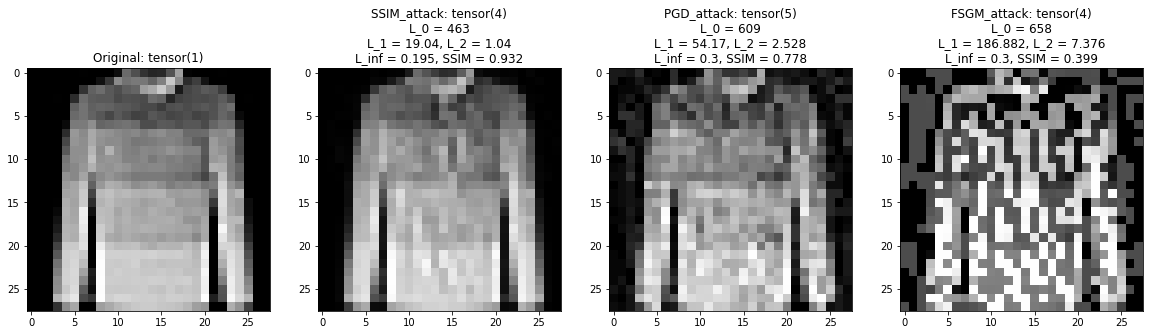

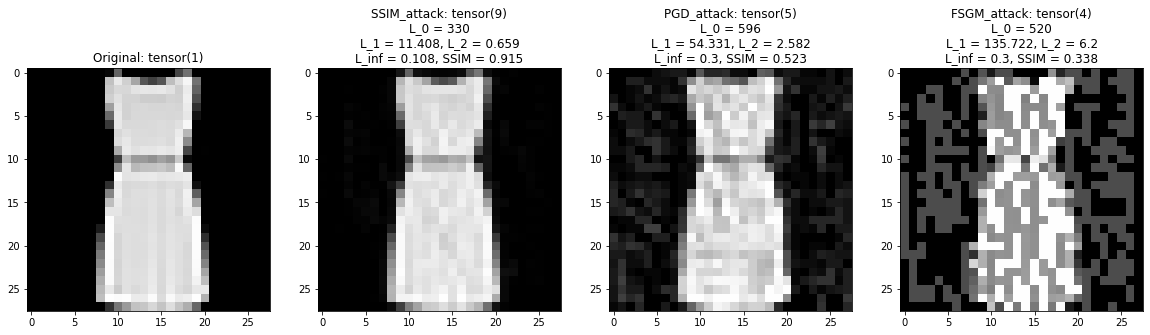

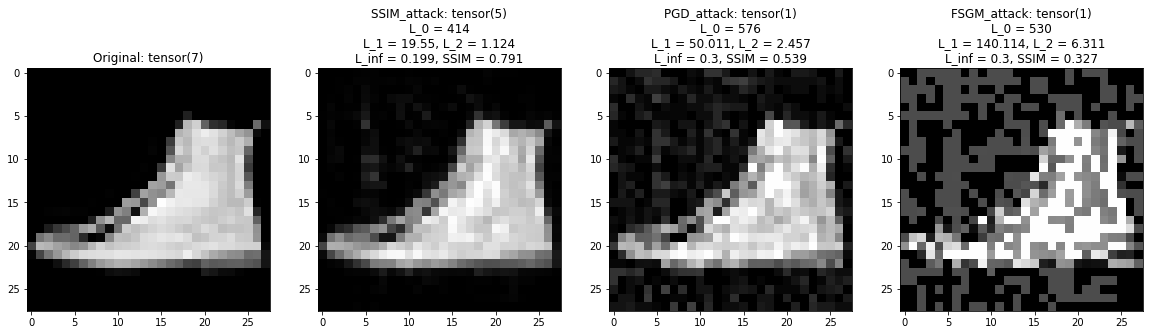

Total Image Count: 490 Success Rate:
 SSIM_attack: 0.9938775510204082 PGD_attack: 1.0 FSGM_attack: 0.9183673469387755 CW_attack: 0.0
Average SSIM: SSIM_attack: 0.934 PGD_attack: 0.619 FSGM_attack: 0.351 CW_attack: 0.0


In [14]:
# PGD TEST
# N = Novel Approach, C = Conventional Approach
model.eval()
success_N = 0
success_C = 0
success_F = 0
success_cw = 0
SSIM_N_total = 0
SSIM_C_total = 0
SSIM_F_total = 0
SSIM_cw_total = 0
total = 0
pred_suc = 0
attpre_suc = 0
batch_num = 0
for images, labels in test_loader:
    batch_num += 1
    images = images.to(device)
    labels = labels.to(device)
    outputs_N = model(images)
    _, ori_preds = torch.max(outputs_N, 1)   #original outputs
    index = np.arange(labels.size(0))
    # print(labels.size())
    index = index[ori_preds.cpu() == labels.cpu()]
    # print(images.size())
    images = images[index]
    labels = labels[index]
    
    #print(images.size())
    # SSIM_attack
    att_images_N, deltas = PGD_attack_MyLoss(model, images, labels, eps, step_size)
    att_outputs_N = model(att_images_N)
    _, att_preds_N = torch.max(att_outputs_N, 1)
    success_N += (labels != att_preds_N).sum().item()
    # success += (ori_preds != att_preds_N).sum().item()
    # pred_suc += (ori_preds == labels).sum().item()
    # attpre_suc += (att_preds_N == labels).sum().item()

    # PGD_attack
    att_images_C, deltas_conv = PGD_attack_Conventional(model, images, labels, eps = eps,step_size=0.025)
    att_outputs_C = model(att_images_C)
    _, att_preds_C = torch.max(att_outputs_C.data, 1)
    success_C += (labels != att_preds_C).sum().item()

    # FSGM_attack
    att_images_F = fsgm_attack(model, images, labels, eps = eps)
    att_outputs_F = model(att_images_F)
    _, att_preds_F = torch.max(att_outputs_F.data, 1)
    success_F += (labels != att_preds_F).sum().item()
    '''
    # CW_attack
    att_images_cw, L_inf_cw = cw_l2_attack(model, images, labels, targeted=False, c=40)
    att_outputs_cw = model(att_images_cw)
    _, att_preds_cw = torch.max(att_outputs_cw.data, 1)
    success_cw += (labels != att_preds_cw).sum().item()
    '''
    # Display Result
    total += labels.size(0)
    for i in range (0, images.size()[0]):
        SSIM_N = pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_N[i].unsqueeze(0)).item()
        SSIM_C = pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_C[i].unsqueeze(0)).item()
        SSIM_F = pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_F[i].unsqueeze(0)).item()
        #SSIM_cw = pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_cw[i].unsqueeze(0)).item()
        SSIM_N_total += SSIM_N
        SSIM_C_total += SSIM_C
        SSIM_F_total += SSIM_F
        #SSIM_cw_total += SSIM_cw
        if(batch_num % 10 == 0):
            l0_N = l0(images[i], att_images_N[i])
            l0_C = l0(images[i], att_images_C[i])
            l0_F = l0(images[i], att_images_F[i])
            #l0_cw = l0(images[i], att_images_cw[i])
            l1_N = l1(images[i], att_images_N[i])
            l1_C = l1(images[i], att_images_C[i])
            l1_F = l1(images[i], att_images_F[i])
            #l1_cw = l1(images[i], att_images_cw[i])
            l2_N = l2(images[i], att_images_N[i])
            l2_C = l2(images[i], att_images_C[i])
            l2_F = l2(images[i], att_images_F[i])
            #l2_cw = l2(images[i], att_images_cw[i])
            imglist = []
            imglist.append(torchvision.utils.make_grid(images[i].data, normalize=True))
            imglist.append(torchvision.utils.make_grid(att_images_N[i].data, normalize=True))
            imglist.append(torchvision.utils.make_grid(att_images_C[i].data, normalize=True))
            imglist.append(torchvision.utils.make_grid(att_images_F[i].data, normalize=True))
            #imglist.append(torchvision.utils.make_grid(att_images_cw[i].data, normalize=True))
            labellist = []
            labellist.append("Original: " + str(test_dataset.test_labels[labels[i]]))
            labellist.append("SSIM_attack: " + str(test_dataset.test_labels[att_preds_N[i]])
                        + '\n' + "L_0 = " + str(round(l0_N, 3)) + '\n' + "L_1 = " + str(round(l1_N,3)) + ", L_2 = " + str(round(l2_N,3))
                        + '\n' + 'L_inf = ' + str(round(deltas[i],3)) + ', SSIM = ' + str(round(SSIM_N,3)))
            labellist.append("PGD_attack: " +str(test_dataset.test_labels[att_preds_C[i]])
                        + '\n' + "L_0 = " + str(round(l0_C, 3)) + '\n' + "L_1 = " + str(round(l1_C,3)) + ", L_2 = " + str(round(l2_C,3))
                        + '\n' + 'L_inf = ' + str(0.3) + ', SSIM = ' + str(round(SSIM_C, 3)))
            labellist.append("FSGM_attack: " +str(test_dataset.test_labels[att_preds_F[i]])
                        + '\n' + "L_0 = " + str(round(l0_F, 3)) + '\n' + "L_1 = " + str(round(l1_F,3)) + ", L_2 = " + str(round(l2_F,3))
                        + '\n' + 'L_inf = ' + str(0.3) + ', SSIM = ' + str(round(SSIM_F, 3)))
            #labellist.append("CW_attack: " +str(test_dataset.test_labels[att_preds_cw[i]])
            #            + '\n' + "L_0 = " + str(round(l0_cw, 3)) + '\n' + "L_1 = " + str(round(l1_cw,3)) + ", L_2 = " + str(round(l2_cw,3))
            #            + '\n' + 'L_inf = ' + str(round(L_inf_cw[i],3)) + ', SSIM = ' + str(round(SSIM_cw, 3)))
            multi_imshow(imglist, labellist)
    print("Total Image Count:", total,"Success Rate:\n", 
              "SSIM_attack:", success_N / total, "PGD_attack:", success_C / total, "FSGM_attack:", success_F / total,
              "CW_attack:", success_cw / total)
    print("Average SSIM: SSIM_attack:",round(SSIM_N_total/total,3), "PGD_attack:",round(SSIM_C_total/total,3)
         ,"FSGM_attack:",round(SSIM_F_total/total,3),"CW_attack:",round(SSIM_cw_total/total,3))
    if(batch_num >=  100):
        break